In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,accuracy_score,f1_score,roc_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, Embedding, LSTM
from keras.utils import to_categorical

from IPython.display import display
import random
import matplotlib.pyplot as plt
# random.seed(10)

In [2]:
# Import Data
games_folder_path = "C:/Users/Craig/Documents/Thesis/Thomas_Gallagher_Thesis/Data/AFL_Stats_sorted/Year/Games/"
games_2012 = pd.read_csv(games_folder_path + '2012.csv', index_col=False, parse_dates=['date'])
games_2013 = pd.read_csv(games_folder_path + '2013.csv', index_col=False, parse_dates=['date'])
games_2014 = pd.read_csv(games_folder_path + '2014.csv', index_col=False, parse_dates=['date'])
games_2015 = pd.read_csv(games_folder_path + '2015.csv', index_col=False, parse_dates=['date'])
games_2016 = pd.read_csv(games_folder_path + '2016.csv', index_col=False, parse_dates=['date'])
games_2017 = pd.read_csv(games_folder_path + '2017.csv', index_col=False, parse_dates=['date'])
games_2018 = pd.read_csv(games_folder_path + '2018.csv', index_col=False, parse_dates=['date'])
games_2019 = pd.read_csv(games_folder_path + '2019.csv', index_col=False, parse_dates=['date'])
games_2020 = pd.read_csv(games_folder_path + '2020.csv', index_col=False, parse_dates=['date'])
games_2021 = pd.read_csv(games_folder_path + '2021.csv', index_col=False, parse_dates=['date'])


all_games = pd.read_csv(games_folder_path + 'games_sorted.csv', index_col=False, parse_dates=['date'])

C:\Users\Craig\AppData\Local\Temp\ipykernel_19268\3458396436.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  games_2012 = pd.read_csv(games_folder_path + '2012.csv', index_col=False, parse_dates=['date'])
C:\Users\Craig\AppData\Local\Temp\ipykernel_19268\3458396436.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  games_2013 = pd.read_csv(games_folder_path + '2013.csv', index_col=False, parse_dates=['date'])
C:\Users\Craig\AppData\Local\Temp\ipykernel_19268\3458396436.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  games_2014 = pd.read_csv(games_

In [3]:
y_true_2012 = games_2012['homeWin']
y_true_2013 = games_2013['homeWin']
y_true_2014 = games_2014['homeWin']
y_true_2015 = games_2015['homeWin']
y_true_2016 = games_2016['homeWin']
y_true_2017 = games_2017['homeWin']
y_true_2018 = games_2018['homeWin']
y_true_2019 = games_2019['homeWin']
y_true_2020 = games_2020['homeWin']
y_true_2021 = games_2021['homeWin']
y_true = all_games['homeWin']

drop_values = ['gameId', 'venue', 'homeWin', 'homeTeam', 'awayTeam', 'year','date','startTime', 'attendance', 'homeTeamScore', 'awayTeamScore', 'round']
with open("features.txt") as f:
    features = f.read().split('\n')
features.append('venue')
features.append('homeTeam')
features.append('awayTeam')

def set_columns(game_list):
    game_list = game_list[features]
    game_list.columns = game_list.columns.astype(str)
    return game_list

games_2012 = set_columns(games_2012)
games_2013 = set_columns(games_2013)
games_2014 = set_columns(games_2014)
games_2015 = set_columns(games_2015)
games_2016 = set_columns(games_2016)
games_2017 = set_columns(games_2017)
games_2018 = set_columns(games_2018)
games_2019 = set_columns(games_2019)
games_2020 = set_columns(games_2020)
games_2021 = set_columns(games_2021)

all_games = set_columns(all_games)

In [4]:
# One Hot Encoding Teams
encoding = LabelEncoder()
encoding.fit(all_games["homeTeam"].values)


def OHE_Teams(games):
    home_teams = encoding.transform(games["homeTeam"].values)
    away_teams = encoding.transform(games["awayTeam"].values)

    all_teams = np.vstack([home_teams, away_teams]).T
 
    oneHot = OneHotEncoder()
    X_teams = oneHot.fit_transform(all_teams).todense()
    X_teams = pd.DataFrame(X_teams)
    games = pd.concat([games, pd.DataFrame(X_teams)],axis=1)
    return games

games_2012 = OHE_Teams(games_2012)
games_2013 = OHE_Teams(games_2013)
games_2014 = OHE_Teams(games_2014)
games_2015 = OHE_Teams(games_2015)
games_2016 = OHE_Teams(games_2016)
games_2017 = OHE_Teams(games_2017)
games_2018 = OHE_Teams(games_2018)
games_2019 = OHE_Teams(games_2019)
games_2020 = OHE_Teams(games_2020)
games_2021 = OHE_Teams(games_2021)

all_games = OHE_Teams(all_games)

In [5]:
# One Hot Encoding Venues
encoding = LabelEncoder()
encoding.fit(all_games["venue"].values)
all_venues = all_games["venue"].values

all_venues = all_venues.reshape(-1,1)

def OHE_Venues(games):
    venues = games['venue'].values
    # all_venues = all_venues.reshape(-1,1)
    venues = venues.reshape(-1,1)
    oneHot = OneHotEncoder()

    oneHot.fit(all_venues)
    X_venues = oneHot.transform(venues).toarray()
    X_venues = pd.DataFrame(X_venues, columns=oneHot.categories_[0])
    games = pd.concat([games, X_venues], axis=1)
    return games

games_2012 = OHE_Venues(games_2012)
games_2013 = OHE_Venues(games_2013)
games_2014 = OHE_Venues(games_2014)
games_2015 = OHE_Venues(games_2015)
games_2016 = OHE_Venues(games_2016)
games_2017 = OHE_Venues(games_2017)
games_2018 = OHE_Venues(games_2018)
games_2019 = OHE_Venues(games_2019)
games_2020 = OHE_Venues(games_2020)
games_2021 = OHE_Venues(games_2021)

all_games = OHE_Venues(all_games)

In [6]:
def drop_columns(game_list):
    game_list = game_list.drop(['venue', 'homeTeam', 'awayTeam'],axis=1)
    game_list.columns = game_list.columns.astype(str)
    return game_list

games_2012 = drop_columns(games_2012)
games_2013 = drop_columns(games_2013)
games_2014 = drop_columns(games_2014)
games_2015 = drop_columns(games_2015)
games_2016 = drop_columns(games_2016)
games_2017 = drop_columns(games_2017)
games_2018 = drop_columns(games_2018)
games_2019 = drop_columns(games_2019)
games_2020 = drop_columns(games_2020)
games_2021 = drop_columns(games_2021)

all_games = drop_columns(all_games)

In [7]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
games_2012 = scaler.fit_transform(games_2012)
games_2013 = scaler.fit_transform(games_2013)
games_2014 = scaler.fit_transform(games_2014)
games_2015 = scaler.fit_transform(games_2015)
games_2016 = scaler.fit_transform(games_2016)
games_2017 = scaler.fit_transform(games_2017)
games_2018 = scaler.fit_transform(games_2018)
games_2019 = scaler.fit_transform(games_2019)
games_2020 = scaler.fit_transform(games_2020)
games_2021 = scaler.fit_transform(games_2021)

all_games = scaler.fit_transform(all_games)

In [8]:
y_train_2012 = y_true_2012[27:171]
y_valid_2012 = y_true_2012[171:]

y_train_2013 = y_true_2013[27:171]
y_valid_2013 = y_true_2013[171:]

y_train_2014 = y_true_2014[27:171]
y_valid_2014 = y_true_2014[171:]

y_train_2015 = y_true_2015[27:170]
y_valid_2015 = y_true_2015[170:]

y_train_2016 = y_true_2016[27:171]
y_valid_2016 = y_true_2016[171:]

y_train_2017 = y_true_2017[27:171]
y_valid_2017 = y_true_2017[171:]

y_train_2018 = y_true_2018[27:171]
y_valid_2018 = y_true_2018[171:]

y_train_2019 = y_true_2019[27:171]
y_valid_2019 = y_true_2019[171:]

y_train_2020 = y_true_2020[27:127]
y_valid_2020 = y_true_2020[127:]

y_train_2021 = y_true_2021[27:171]
y_valid_2021 = y_true_2021[171:]

y_train = y_true[:1447]
y_valid = y_true[1447:1655]

In [9]:
# OHE Y values
oneHot = OneHotEncoder()
def OHE_y_values(y_val):
    y = np.vstack([y_val]).T
    
    # for i in range(len(y)):
    #     if y[i] == 1:
    #         y[i] = 0

    y_OHE = oneHot.fit_transform(y).toarray()

    return y_OHE


y_train_2012_OHE = OHE_y_values(y_train_2012)
y_valid_2012_OHE = OHE_y_values(y_valid_2012)

y_train_2013_OHE = OHE_y_values(y_train_2013)
y_valid_2013_OHE = OHE_y_values(y_valid_2013)

y_train_2014_OHE = OHE_y_values(y_train_2014)
y_valid_2014_OHE = OHE_y_values(y_valid_2014)

y_train_2015_OHE = OHE_y_values(y_train_2015)
y_valid_2015_OHE = OHE_y_values(y_valid_2015)

y_train_2016_OHE = OHE_y_values(y_train_2016)
y_valid_2016_OHE = OHE_y_values(y_valid_2016)

y_train_2017_OHE = OHE_y_values(y_train_2017)
y_valid_2017_OHE = OHE_y_values(y_valid_2017)

y_train_2018_OHE = OHE_y_values(y_train_2018)
y_valid_2018_OHE = OHE_y_values(y_valid_2018)

y_train_2019_OHE = OHE_y_values(y_train_2019)
y_valid_2019_OHE = OHE_y_values(y_valid_2019)

y_train_2020_OHE = OHE_y_values(y_train_2020)
y_valid_2020_OHE = OHE_y_values(y_valid_2020)

y_train_2021_OHE = OHE_y_values(y_train_2021)
y_valid_2021_OHE = OHE_y_values(y_valid_2021)

y_train_OHE = OHE_y_values(y_train)
y_valid_OHE = OHE_y_values(y_valid)

In [10]:
def set_window(games):
    y = 0 #
    p = 0 # round 0
    # d_full = np.zeros(shape=(1980,75))
    d_full = np.zeros(shape=(5040,75)) # (207 - 18) * 18 + (207 - 18)
    for x in range(0,d_full.shape[0],28): # For games in each round corresponds to d_full, when a round is ended it jumps over the added games
        y = 27 # link to previous rounds
        if x % 252 == 0: # Games in each round * added games
            p += 1 # move to next round when 90 index is reached
        for i in range(27): # fills out the first 18 posistions in the window with previous games
            d_full[x+i] = games[p+i] # at pos x add corresponding previous game
        d_full[x+y] = games[x//28 + y] # add game in question to final position
    
    d_Train = d_full[:4032]
    d_valid = d_full[4032:]
    d_Train = np.reshape(d_Train, (144, 28,75))
    d_valid = np.reshape(d_valid, (36, 28, 75))
    return d_Train, d_valid

x_train_2012, x_valid_2012 = set_window(games_2012)
x_train_2013, x_valid_2013 = set_window(games_2013)
x_train_2014, x_valid_2014 = set_window(games_2014)
# x_train_2015, x_valid_2015 = set_window(games_2015)
x_train_2016, x_valid_2016 = set_window(games_2016)
x_train_2017, x_valid_2017 = set_window(games_2017)
x_train_2018, x_valid_2018 = set_window(games_2018)
x_train_2019, x_valid_2019 = set_window(games_2019)
# x_train_2020, x_valid_2020 = set_window(games_2020)

In [13]:
def set_window_2015(games):
    y = 0
    p = 0
    d_full = np.zeros(shape=(5012,75))
    for x in range(0,d_full.shape[0],28): # Goes through index for each round
        y = 27 # link to previous round
        if x % 252 == 0:
            p += 1 # move to next round when 90 index is reached
        for i in range(27): # fills out the first nine posistions in the window with previous games
                d_full[x+i] = games[p+i] # at pos x add corresponding previous game
            
        d_full[x+y] = games[x//28 + y] # add game in question to final position
        
    d_Train = d_full[:4004]
    d_valid = d_full[4004:]
    d_Train = np.reshape(d_Train, (143, 28,75))
    d_valid = np.reshape(d_valid, (36, 28, 75))
    return d_Train, d_valid

x_train_2015, x_valid_2015 = set_window_2015(games_2015)


In [21]:
def train_model_3( xTrain, yTrain, xValid , yValid):
    random.seed(26)
    model = Sequential()
    model.add(LSTM( 64 ,input_shape = (28,75), activation = 'tanh' , dropout = 0.3, recurrent_dropout = 0.3))
    model.add(Dense(2, activation="tanh"))
    model.build()   
    model.summary()
    model.compile( optimizer = "rmsprop" , loss = 'mean_squared_error' , metrics = ['accuracy', 'mse'])

    reduce_lr = ReduceLROnPlateau( monitor = 'accuracy', factor = 0.01, patience=10, cooldown=0)
    
    callbacks = [ reduce_lr ]
    model.fit( xTrain, yTrain , epochs = 50, shuffle=False, callbacks=callbacks, verbose = 2)

    # train_history = model.fit( x_train_2012 , y_train_2012 , epochs = 10, validation_split = 0.1 , verbose = 1 )
    score = model.evaluate( xValid , yValid )
    pred = model.predict(xValid)
    model.save("LSTM_3")
    # print( f"Train Accuracy: {train_history.history}" )
    
    print( "Accuracy: {:0.4}".format( score[1] ))
    print( "Loss:", score[0] )
    return score, pred


In [24]:
results_2012, pred_2012 = train_model_3(x_train_2012, y_train_2012_OHE, x_valid_2012, y_valid_2012_OHE) 
results_2013, pred_2013 = train_model_3(x_train_2013, y_train_2013_OHE, x_valid_2013, y_valid_2013_OHE) 
results_2014, pred_2014 = train_model_3(x_train_2014, y_train_2014_OHE, x_valid_2014, y_valid_2014_OHE) 
results_2015, pred_2015 = train_model_3(x_train_2015, y_train_2015_OHE, x_valid_2015, y_valid_2015_OHE) 
results_2016, pred_2016 = train_model_3(x_train_2016, y_train_2016_OHE, x_valid_2016, y_valid_2016_OHE) 
results_2017, pred_2017 = train_model_3(x_train_2017, y_train_2017_OHE, x_valid_2017, y_valid_2017_OHE) 
results_2018, pred_2018 = train_model_3(x_train_2018, y_train_2018_OHE, x_valid_2018, y_valid_2018_OHE) 
results_2019, pred_2019 = train_model_3(x_train_2019, y_train_2019_OHE, x_valid_2019, y_valid_2019_OHE)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 64)                35840     
                                                                 
 dense_17 (Dense)            (None, 2)                 130       
                                                                 
Total params: 35,970
Trainable params: 35,970
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 4s - loss: 0.3224 - accuracy: 0.5069 - mse: 0.3224 - lr: 0.0010 - 4s/epoch - 721ms/step
Epoch 2/50
5/5 - 0s - loss: 0.2499 - accuracy: 0.5417 - mse: 0.2499 - lr: 0.0010 - 153ms/epoch - 31ms/step
Epoch 3/50
5/5 - 0s - loss: 0.2498 - accuracy: 0.5556 - mse: 0.2498 - lr: 0.0010 - 133ms/epoch - 27ms/step
Epoch 4/50
5/5 - 0s - loss: 0.2396 - accuracy: 0.5694 - mse: 0.2396 - lr: 0.0010 - 138ms/epoch - 28ms/step
Epoch 5/50
5/5 - 0s

INFO:tensorflow:Assets written to: LSTM_3\assets


INFO:tensorflow:Assets written to: LSTM_3\assets


Accuracy: 0.5556
Loss: 0.2685176432132721
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 64)                35840     
                                                                 
 dense_18 (Dense)            (None, 2)                 130       
                                                                 
Total params: 35,970
Trainable params: 35,970
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 3s - loss: 0.2856 - accuracy: 0.6250 - mse: 0.2856 - lr: 0.0010 - 3s/epoch - 617ms/step
Epoch 2/50
5/5 - 0s - loss: 0.2299 - accuracy: 0.6736 - mse: 0.2299 - lr: 0.0010 - 110ms/epoch - 22ms/step
Epoch 3/50
5/5 - 0s - loss: 0.2252 - accuracy: 0.6528 - mse: 0.2252 - lr: 0.0010 - 109ms/epoch - 22ms/step
Epoch 4/50
5/5 - 0s - loss: 0.2242 - accuracy: 0.6389 - mse: 0.2242 - lr: 0.0010 - 1

INFO:tensorflow:Assets written to: LSTM_3\assets


INFO:tensorflow:Assets written to: LSTM_3\assets


Accuracy: 0.5833
Loss: 0.26423320174217224
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 64)                35840     
                                                                 
 dense_19 (Dense)            (None, 2)                 130       
                                                                 
Total params: 35,970
Trainable params: 35,970
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 3s - loss: 0.2976 - accuracy: 0.5833 - mse: 0.2976 - lr: 0.0010 - 3s/epoch - 612ms/step
Epoch 2/50
5/5 - 0s - loss: 0.2391 - accuracy: 0.5903 - mse: 0.2391 - lr: 0.0010 - 112ms/epoch - 22ms/step
Epoch 3/50
5/5 - 0s - loss: 0.2321 - accuracy: 0.6250 - mse: 0.2321 - lr: 0.0010 - 116ms/epoch - 23ms/step
Epoch 4/50
5/5 - 0s - loss: 0.2273 - accuracy: 0.6528 - mse: 0.2273 - lr: 0.0010 - 

INFO:tensorflow:Assets written to: LSTM_3\assets


INFO:tensorflow:Assets written to: LSTM_3\assets


Accuracy: 0.6389
Loss: 0.2399144470691681
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 64)                35840     
                                                                 
 dense_20 (Dense)            (None, 2)                 130       
                                                                 
Total params: 35,970
Trainable params: 35,970
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 4s - loss: 0.3029 - accuracy: 0.4895 - mse: 0.3029 - lr: 0.0010 - 4s/epoch - 726ms/step
Epoch 2/50
5/5 - 0s - loss: 0.2458 - accuracy: 0.5385 - mse: 0.2458 - lr: 0.0010 - 148ms/epoch - 30ms/step
Epoch 3/50
5/5 - 0s - loss: 0.2385 - accuracy: 0.5804 - mse: 0.2385 - lr: 0.0010 - 107ms/epoch - 21ms/step
Epoch 4/50
5/5 - 0s - loss: 0.2384 - accuracy: 0.5734 - mse: 0.2384 - lr: 0.0010 - 1

INFO:tensorflow:Assets written to: LSTM_3\assets


INFO:tensorflow:Assets written to: LSTM_3\assets


Accuracy: 0.6111
Loss: 0.21228629350662231
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 64)                35840     
                                                                 
 dense_21 (Dense)            (None, 2)                 130       
                                                                 
Total params: 35,970
Trainable params: 35,970
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 3s - loss: 0.3074 - accuracy: 0.6181 - mse: 0.3074 - lr: 0.0010 - 3s/epoch - 613ms/step
Epoch 2/50
5/5 - 0s - loss: 0.2412 - accuracy: 0.6111 - mse: 0.2412 - lr: 0.0010 - 175ms/epoch - 35ms/step
Epoch 3/50
5/5 - 0s - loss: 0.2392 - accuracy: 0.5972 - mse: 0.2392 - lr: 0.0010 - 123ms/epoch - 25ms/step
Epoch 4/50
5/5 - 0s - loss: 0.2349 - accuracy: 0.6111 - mse: 0.2349 - lr: 0.0010 - 

INFO:tensorflow:Assets written to: LSTM_3\assets


INFO:tensorflow:Assets written to: LSTM_3\assets


Accuracy: 0.5278
Loss: 0.260100781917572
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 64)                35840     
                                                                 
 dense_22 (Dense)            (None, 2)                 130       
                                                                 
Total params: 35,970
Trainable params: 35,970
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 3s - loss: 0.3072 - accuracy: 0.5764 - mse: 0.3072 - lr: 0.0010 - 3s/epoch - 617ms/step
Epoch 2/50
5/5 - 0s - loss: 0.2502 - accuracy: 0.5833 - mse: 0.2502 - lr: 0.0010 - 112ms/epoch - 22ms/step
Epoch 3/50
5/5 - 0s - loss: 0.2415 - accuracy: 0.5764 - mse: 0.2415 - lr: 0.0010 - 115ms/epoch - 23ms/step
Epoch 4/50
5/5 - 0s - loss: 0.2463 - accuracy: 0.5625 - mse: 0.2463 - lr: 0.0010 - 10

INFO:tensorflow:Assets written to: LSTM_3\assets


INFO:tensorflow:Assets written to: LSTM_3\assets


Accuracy: 0.7222
Loss: 0.18795382976531982
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 64)                35840     
                                                                 
 dense_23 (Dense)            (None, 2)                 130       
                                                                 
Total params: 35,970
Trainable params: 35,970
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 4s - loss: 0.3033 - accuracy: 0.5069 - mse: 0.3033 - lr: 0.0010 - 4s/epoch - 719ms/step
Epoch 2/50
5/5 - 0s - loss: 0.2412 - accuracy: 0.5833 - mse: 0.2412 - lr: 0.0010 - 140ms/epoch - 28ms/step
Epoch 3/50
5/5 - 0s - loss: 0.2368 - accuracy: 0.6250 - mse: 0.2368 - lr: 0.0010 - 106ms/epoch - 21ms/step
Epoch 4/50
5/5 - 0s - loss: 0.2348 - accuracy: 0.5833 - mse: 0.2348 - lr: 0.0010 - 

INFO:tensorflow:Assets written to: LSTM_3\assets


INFO:tensorflow:Assets written to: LSTM_3\assets


Accuracy: 0.75
Loss: 0.17583265900611877
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 64)                35840     
                                                                 
 dense_24 (Dense)            (None, 2)                 130       
                                                                 
Total params: 35,970
Trainable params: 35,970
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 3s - loss: 0.3076 - accuracy: 0.5694 - mse: 0.3076 - lr: 0.0010 - 3s/epoch - 616ms/step
Epoch 2/50
5/5 - 0s - loss: 0.2503 - accuracy: 0.5972 - mse: 0.2503 - lr: 0.0010 - 107ms/epoch - 21ms/step
Epoch 3/50
5/5 - 0s - loss: 0.2432 - accuracy: 0.5833 - mse: 0.2432 - lr: 0.0010 - 112ms/epoch - 22ms/step
Epoch 4/50
5/5 - 0s - loss: 0.2397 - accuracy: 0.5764 - mse: 0.2397 - lr: 0.0010 - 10

INFO:tensorflow:Assets written to: LSTM_3\assets


INFO:tensorflow:Assets written to: LSTM_3\assets


Accuracy: 0.7222
Loss: 0.2195657342672348


In [26]:
results = pd.DataFrame(data = [results_2012[:2],results_2013[:2],results_2014[:2],results_2015[:2],results_2016[:2],
                               results_2017[:2],results_2018[:2],results_2019[:2]],
                            index = ['2012', '2013', '2014','2015','2016','2017','2018','2019'],
                            columns = ['loss', 'accuracy'])
sum(results['accuracy'])/8


0.6388888880610466

(Text(0.5, 1.0, '2018'), Text(0.5, 1.0, '2019'))

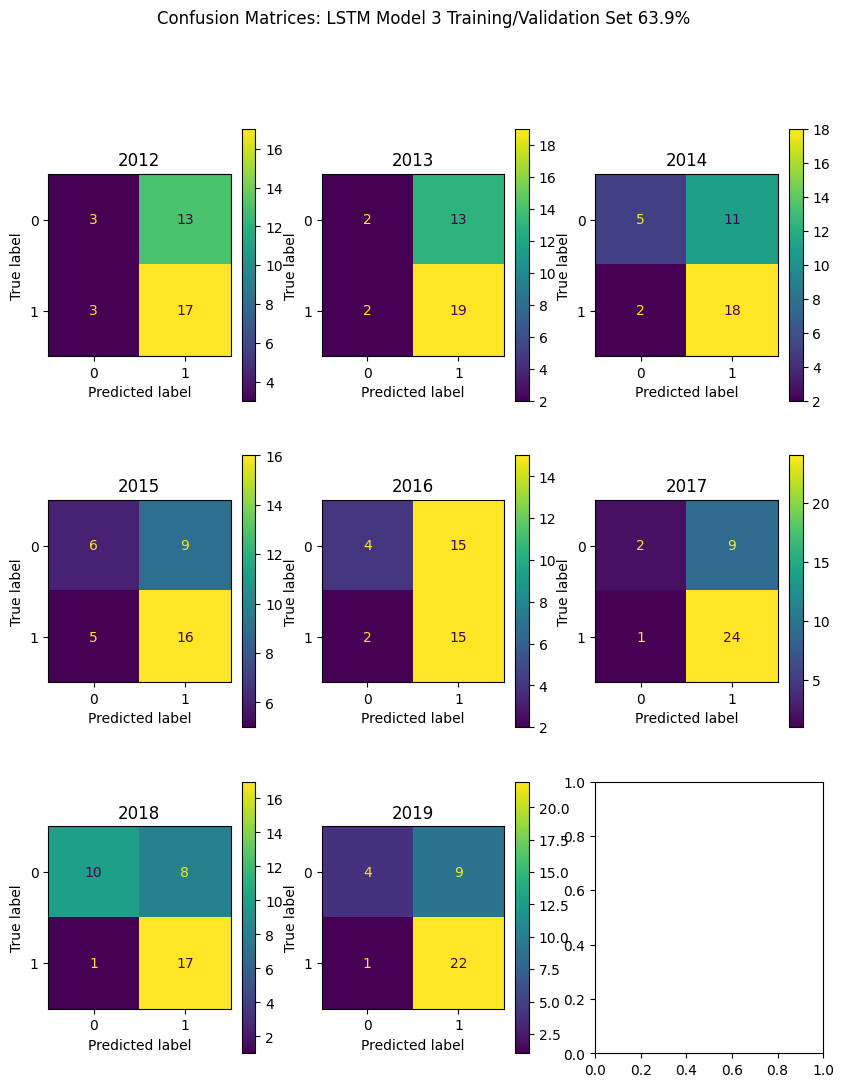

In [28]:
def build_conf_matrix(prediction, true):
    s = 0
    pl = []
    for pred in prediction:
        if pred[0] > pred[1]:
            pl.append(0)
        else:
            pl.append(1)

    for i in range(len(pl)):
        if pl[i] == true.values[i]:
            s+=1

    c_train = confusion_matrix(true, pl)
    disp = ConfusionMatrixDisplay(c_train)
    return disp

cf_2012 = build_conf_matrix(pred_2012, y_valid_2012)
cf_2013 = build_conf_matrix(pred_2013, y_valid_2013)
cf_2014 = build_conf_matrix(pred_2014, y_valid_2014)
cf_2015 = build_conf_matrix(pred_2015, y_valid_2015)
cf_2016 = build_conf_matrix(pred_2016, y_valid_2016)
cf_2017 = build_conf_matrix(pred_2017, y_valid_2017)
cf_2018 = build_conf_matrix(pred_2018, y_valid_2018)
cf_2019 = build_conf_matrix(pred_2019, y_valid_2019)


fig, ax = plt.subplots(3,3)
fig.set_figwidth(10)
fig.set_figheight(12)
fig.suptitle("Confusion Matrices: LSTM Model 3 Training/Validation Set 63.9%")
cf_2012.plot(ax=ax[0][0]), cf_2013.plot(ax=ax[0][1]), cf_2014.plot(ax=ax[0][2])
cf_2015.plot(ax=ax[1][0]), cf_2016.plot(ax=ax[1][1]), cf_2017.plot(ax=ax[1][2])
cf_2018.plot(ax=ax[2][0]), cf_2019.plot(ax=ax[2][1])

ax[0][0].set_title(2012), ax[0][1].set_title(2013), ax[0][2].set_title(2014)
ax[1][0].set_title(2015), ax[1][1].set_title(2016), ax[1][2].set_title(2017)
ax[2][0].set_title(2018), ax[2][1].set_title(2019)

Res_1 =   model.add(LSTM( 128 ,input_shape = (88,1), activation = 'tanh' , dropout = 0.25, recurrent_dropout = 0.25, return_sequences=True))
    model.add(LSTM( 64 ))
    model.add(Dense(2, activation="tanh"))

Res_2 =   model.add(LSTM( 128 ,input_shape = (88,1), activation = 'sigmoid' , dropout = 0.25, recurrent_dropout = 0.25, return_sequences=True))
    model.add(LSTM( 64 ))
    model.add(Dense(2, activation="tanh"))

Res_3 =   model.add(LSTM( 128 ,input_shape = (88,1), activation = 'tanh' , dropout = 0.25, recurrent_dropout = 0.25, return_sequences=True))
    model.add(LSTM( 64, activation='tanh ))
    model.add(Dense(2, activation="tanh"))

Res_4 =   model.add(LSTM( 128 ,input_shape = (88,1), activation = 'tanh' , dropout = 0.2, recurrent_dropout = 0.2, return_sequences=True))
    model.add(LSTM( 64 ))
    model.add(Dense(2, activation="tanh"))

Res_5 =   model.add(LSTM( 128 ,input_shape = (88,1), activation = 'tanh' , dropout = 0.3, recurrent_dropout = 0.3, return_sequences=True))
    model.add(LSTM( 64 ))
    model.add(Dense(2, activation="tanh"))


Res_6 =   model.add(LSTM( 128 ,input_shape = (88,1), activation = 'tanh' , dropout = 0.4, recurrent_dropout = 0.4, return_sequences=True))
    model.add(LSTM( 64 ))
    model.add(Dense(2, activation="tanh"))

Res_7 =   model.add(LSTM( 128 ,input_shape = (88,1), activation = 'tanh' , dropout = 0.3, recurrent_dropout = 0.3, return_sequences=True))
    model.add(LSTM( 64, return_sequences=True))
    model.add(LSTM( 64 ))
    model.add(Dense(64, activation="tanh))
    model.add(Dense(2, activation="tanh"))

Res_8 =   model.add(LSTM( 128 ,input_shape = (88,1), activation = 'tanh' , dropout = 0.3, recurrent_dropout = 0.3, return_sequences=True))
    model.add(LSTM( 64, return_sequences=True, dropout = 0.3))
    model.add(LSTM( 64 ))
    model.add(Dense(32, activation="tanh))
    model.add(Dense(2, activation="tanh"))

Res_10 = model.add(LSTM( 128 ,input_shape = (88,1), activation = 'tanh' , dropout = 0.3, recurrent_dropout = 0.3, return_sequences=True))
    model.add(LSTM( 64, return_sequences=True, dropout=0.3))
    model.add(LSTM( 32, return_sequences=True, dropout= .1 ))
    model.add(LSTM( 16, return_sequences=True ))
    model.add(Dense(8))
    model.add(LSTM( 32 ))
    # model.add(LSTM( 64 ))
    model.add(Dense(32, activation="tanh"))    
    model.add(Dense(16, activation="tanh"))
    model.add(Dense(2, activation="tanh"))

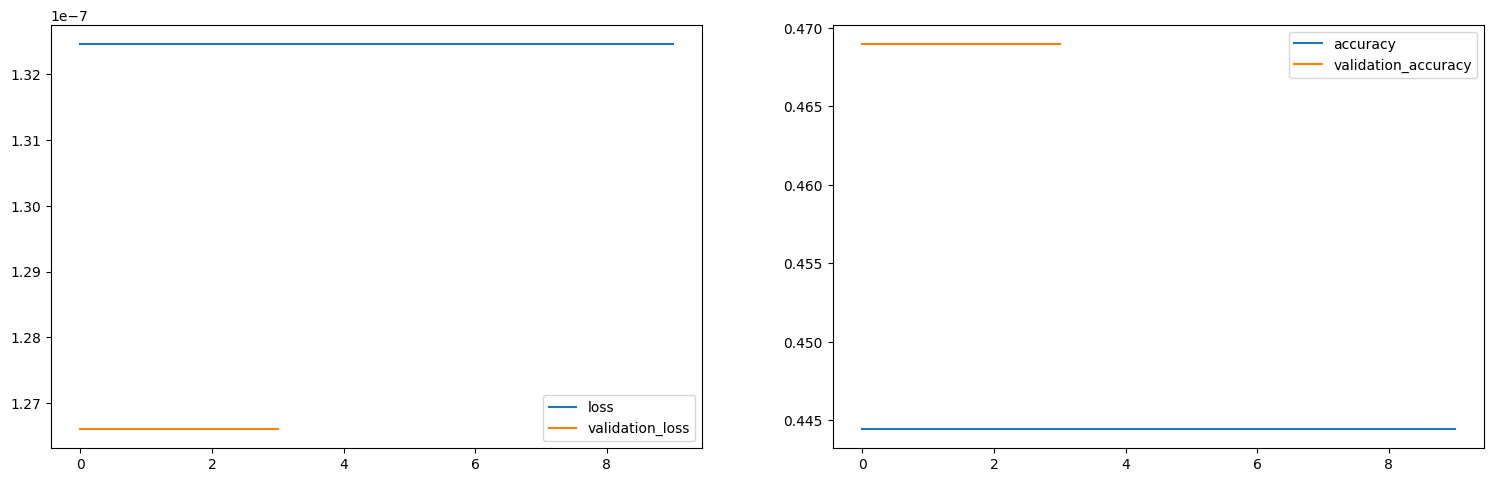

In [57]:
loss = train_history.history['loss']
# validation_loss = train_history.history['val_loss']
accuracy = train_history.history['accuracy']
# val_accuracy = train_history.history['val_accuracy']

fig = plt.gcf()
fig.set_size_inches(18.5, 5.5)
plt.subplot(1,2,1)
plt.plot(loss)
plt.plot(validation_loss)
plt.legend(['loss', 'validation_loss'])
plt.subplot(1,2,2)
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy', 'validation_accuracy'])
plt.show()